In [18]:
!uv add Pillow
!uv add matplotlib
!uv add sentence-transformers
!uv add ipywidgets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolved 160 packages in 14ms
Audited 56 packages in 17ms
Resolved 160 packages in 3ms
Audited 56 packages in 1ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolved 160 packages in 3ms
Audited 56 packages in 1ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


⠙ ipynb==0.1.0                                                                  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolved 163 packages in 802ms                                       
⠹ Preparing packages... (0/3)                                                   
⠹ Preparing packages... (0/3)-------------------     0 B/136.53 KiB          
⠹ Preparing packages... (0/3)------------------- 16.00 KiB/136.53 KiB        
⠹ Preparing packages... (0/3)------------------- 32.00 KiB/136.53 KiB        
⠹ Preparing packages... (0/3)------------------- 48.00 KiB/136.53 KiB        
⠹ Preparing packages... (0/3)2m----------------- 60.12 KiB/136.53 KiB        
⠹ Preparing packages... (0/3)2m----------------- 60.12 KiB/136.53 KiB        
ipywidgets           ------------------------------ 60.12 KiB/136.53 KiB
⠹ Preparing packages... (0/3)-------------------     0 B/2.09 MiB            
ipywidgets           ------------------------------ 60.12 KiB/136.53 KiB
⠹ Preparing packages... (0/3)-------------------     0 B/2.09 MiB            
ipywidgets           ------------------------------ 60.12 KiB/136.53 KiB
⠹ Prep

In [3]:
from urllib.request import urlopen
from PIL import Image

# 加载一张小狗在雪地里玩耍的AI生成的图像
puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
image = Image.open(urlopen(puppy_path)).convert("RGB")
caption = "a puppy playing in the snow"

In [4]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# 加载分词器来预处理文本
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
# 加载预处理器来预处理图像
clip_processor = CLIPProcessor.from_pretrained(model_id)
# 用于生成文本嵌入和图像嵌入的主模型
model = CLIPModel.from_pretrained(model_id)

/Users/ohmycloud/opt/learning/llm/hands-on-large-language-model/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 对输入进行分词
inputs = clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [6]:
# 将输入转换为词元
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [7]:
# 创建文本嵌入
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [8]:
# 预处理图像
processed_image = clip_processor(
    text=None, images=image, return_tensors="pt"
)["pixel_values"]
processed_image.shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

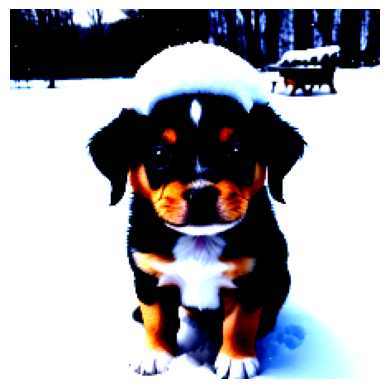

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 准备图像以进行可视化
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum("ijk->jik", img)

# 可视化预处理后的图像
plt.imshow(img)
plt.axis("off")

In [11]:
# 创建图像嵌入
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [12]:
# 对嵌入向量进化归一化处理
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# 计算它们的相似度
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()

score = np.dot(text_embedding, image_embedding.T)
score

array([[0.33149627]], dtype=float32)

In [15]:
from sentence_transformers import SentenceTransformer, util
from urllib.request import urlopen
from PIL import Image

# 加载一张小狗在雪地里玩耍的AI生成的图像
puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
cat_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png"
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"

images = [Image.open(urlopen(img_path)).convert("RGB") for img_path in [puppy_path, cat_path, car_path]]
captions = ["a puppy playing in the snow", "A pixelated image of a cute cat", "A supercar on the road with the sunset in the background"]

# 加载兼容SBERT的CLIP模型
model = SentenceTransformer("clip-ViT-B-32")
# 对图像进行编码
image_embeddings = model.encode(images)
# 对描述文本进行编码
text_embeddings = model.encode(captions)
# 计算余弦相似度
sim_matrix = util.cos_sim(
    image_embeddings, text_embeddings
)
sim_matrix


tensor([[0.3315, 0.1863, 0.1084],
        [0.1488, 0.3463, 0.0947],
        [0.0762, 0.1260, 0.3098]])

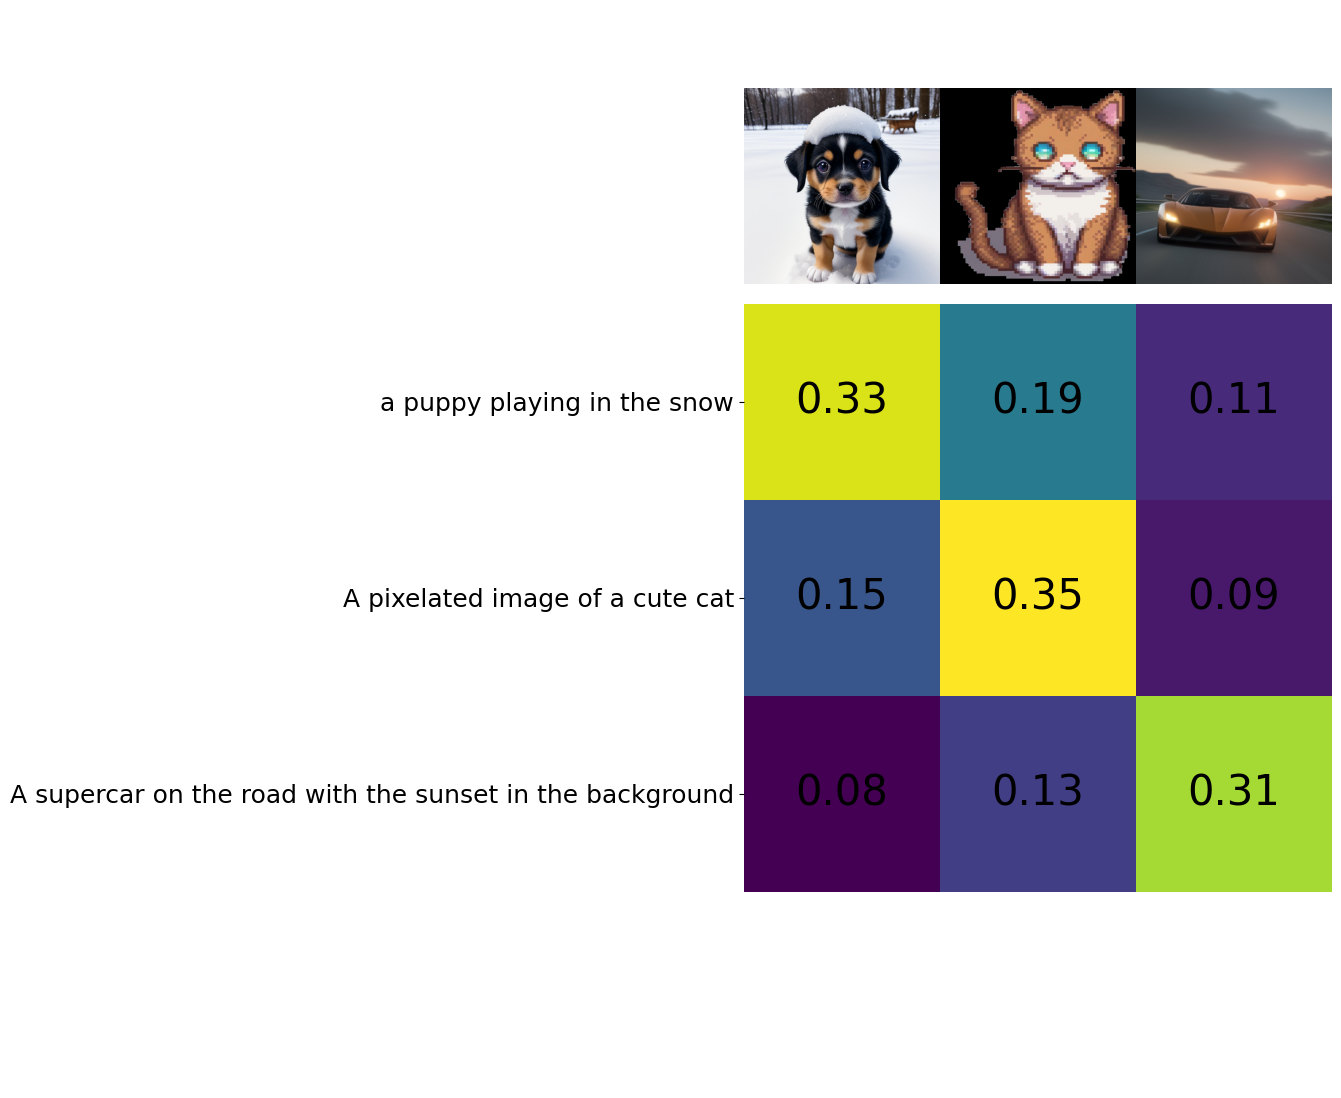

In [17]:
# create base figure
plt.figure(figsize=(20, 14))
plt.imshow(sim_matrix, cmap='viridis')

# adjust ticks with correct labels
plt.yticks(range(len(captions)), captions, fontsize=18)
plt.xticks([])

# visualize
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# add the captions at the correct indices
for x in range(sim_matrix.shape[1]):
    for y in range(sim_matrix.shape[0]):
        plt.text(x, y, f"{sim_matrix[y, x]:.2f}", ha="center", va="center", size=30)

# remove unnecessary spines
for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

# resize blocks
plt.xlim([-0.5, len(captions) - 0.5])
plt.ylim([len(captions) + 0.5, -2])
# plt.title("Similarity Matrix", size=20)
plt.savefig("sim_matrix.png", dpi=300, bbox_inches='tight')

In [1]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# 加载处理器和主模型
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16
)
# 将模型发送到GPU以加速推理
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/Users/ohmycloud/opt/learning/llm/hands-on-large-language-model/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:26<00:00, 13.22s/it]


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

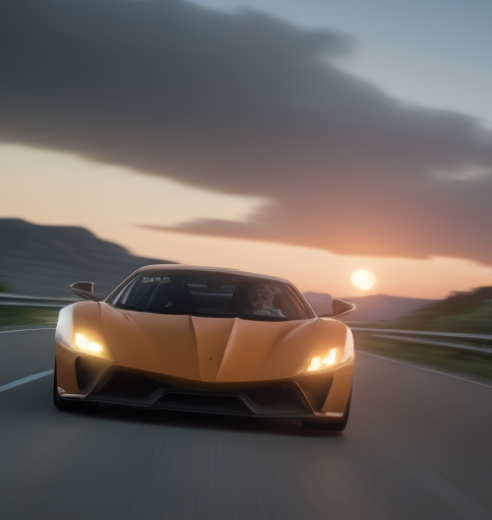

In [4]:
# 加载跑车图像
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert("RGB")
image

In [5]:
# 预处理图像
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [6]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50265: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [7]:
# 预处理文本
text = "Her vocalization was remarkably melodic"
token_ids = blip_processor(image, text=text, return_tensors="pt")
token_ids = token_ids.to(device, torch.float16)["input_ids"][0]
# 将输入ID转换回词元
tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 'Ġvocal',
 'ization',
 'Ġwas',
 'Ġremarkably',
 'Ġmel',
 'odic']

In [8]:
# 将空格词元替换为下划线
tokens = [token.replace("Ġ", "_") for token in tokens]
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 '_vocal',
 'ization',
 '_was',
 '_remarkably',
 '_mel',
 'odic']

In [9]:
# 为图像生成将被传递给解码器(LLM)的词元ID
generated_ids = model.generate(**inputs, max_new_tokens=20)
# 从词元ID生成文本
generated_text = blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
generated_text = generated_text[0].strip()
generated_text

'an orange supercar driving on the road at sunset'

In [13]:
# 加载测验图像
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")
# 生成描述
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
generated_text = generated_text[0].strip()
generated_text

HTTPError: HTTP Error 403: Forbidden

In [14]:
# 加载一张AI生成的跑车图像
image = Image.open(urlopen(car_path)).convert("RGB")

In [15]:
# 视觉问答
prompt = "Question: Write down what you see in this picture. Answer:"
# 同时处理图像和提示词
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
# 生成文本
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
generated_text = generated_text[0].strip()
generated_text

'Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset'

In [16]:
# 类聊天式提示词
prompt = "Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset. Question: What would it cost me to drive that car? Answer:"
# 生成输出
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
generated_text = generated_text[0].strip()
generated_text

'Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset. Question: What would it cost me to drive that car? Answer: $1,000,000'

In [ ]:
from IPython.display import HTML, display
import ipywidgets as widgets

def text_eventhandler(*args):
  question = args[0]["new"]
  if question:
    args[0]["owner"].value = ""
    # 创建提示词
    if not memory:
      prompt = " Question: " + question + " Answer:"
    else:
      template = "Question: {} Answer: {}."
      prompt = " ".join(
          [
              template.format(memory[i][0], memory[i][1])
              for i in range(len(memory))
          ]
      ) + " Question: " + question + " Answer:"
    # 生成文本
    inputs = blip_processor(image, text=prompt, return_tensors="pt")
    inputs = inputs.to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=100)
    generated_text = blip_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )
    generated_text = generated_text[0].strip().split("Question")[0]
    # 更新记忆
    memory.append((question, generated_text))
    # 分配到输出
    output.append_display_data(HTML("<b>USER:</b> " + question))
    output.append_display_data(HTML("<b>BLIP-2:</b> " + generated_text))
    output.append_display_data(HTML("<br>"))
# 准备组件
in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()
memory = []
# 显示聊天框
display(
    widgets.VBox(
        children=[output, in_text],
        layout=widgets.Layout(display="inline-flex", flex_flow="columnreverse"),
    )
)